In [1]:
import pandas as pd
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdmolops
from rdkit.Chem import rdCoordGen
import pandas as pd
import numpy as np
from itertools import product, permutations, combinations
import sys
import os
import random
import warnings
from sklearn.exceptions import InconsistentVersionWarning
import matplotlib.pyplot as plt

# Suppress InconsistentVersionWarning
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)
# Assuming 'cyclpept-ML-models' is in the same directory as your script
# Get the absolute path to the 'cyclpept-ML-models' directory
path_to_cyclpept_ml = os.path.abspath('cyclpept-ML-models')

# Add this path to the sys.path list
sys.path.append(path_to_cyclpept_ml)

from models.apply_model import make_predictions

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
/home/kelmanson/miniforge3/envs/dspy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading some Tensorflow models, missing a dependency. No module named 'tensorflow'
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/kelmanson/miniforge3/envs/dspy/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependen

In [2]:
def filter_for_non_polar_AA(df):
    return df.loc[df['Type of side chaind'] != 'Polar']
def price_filter(df, price_limit):
    return df.loc[df['Cheapest Price (EUR/g)'] <= price_limit]

In [3]:

# def backbone_diversity(set_df):
#     unique_backbones = set_df['Backbonec'].unique()
#     return len(unique_backbones)

# def side_chain_diversity(set_df):
#     unique_side_chains = set_df['Type of side chaind'].unique()
#     return len(unique_side_chains)

# def calculate_diversity_score(set_df):
#     backbone_score = backbone_diversity(set_df)
#     side_chain_score = side_chain_diversity(set_df)
#     return (backbone_score + side_chain_score) / 2

# def generate_diverse_sets(df, num_sets=1, set_size=31, num_trials=1000):
#     """
#     Generate diverse sets of amino acids from the dataframe.

#     Parameters:
#     - df: DataFrame containing amino acid data.
#     - num_sets: Number of diverse sets to generate.
#     - set_size: Number of amino acids in each set.
#     - num_trials: Number of random trials to perform in search for diverse sets.

#     Returns:
#     - A list of dataframes, each representing a diverse set of amino acids.
#     """
#     top_sets = []
#     top_scores = []

#     for _ in range(num_trials):
#         sample_df = df.sample(n=set_size)
#         diversity_score = calculate_diversity_score(sample_df)
        
#         if len(top_scores) < num_sets:
#             top_sets.append(sample_df)
#             top_scores.append(diversity_score)
#         else:
#             min_score = min(top_scores)
#             if diversity_score > min_score:
#                 min_index = top_scores.index(min_score)
#                 top_sets[min_index] = sample_df
#                 top_scores[min_index] = diversity_score

#     return top_sets, top_scores

# Generate the sets


# # Example output
# print("Diversity Scores of the Top Sets:", top_scores)


def generate_name_permutations(df, min_names, max_names, allow_repetitions=True):
    all_permutations_set = set()
    
    unique_names = df['Name'].unique()  # Ensure unique names are used
    print(f"Unique Names Count: {len(unique_names)}")  # Debug: Print unique names count
    
    for r in range(min_names, max_names + 1):
        if allow_repetitions:
            combination_generator = product(unique_names, repeat=r)
        else:
            if len(unique_names) < r:
                print(f"Cannot generate permutations of length {r} without repetitions from {len(unique_names)} unique names.")
                continue  # Skip to next iteration if not enough unique names
            combination_generator = combinations(unique_names, r)
        
        for combination in combination_generator:
            for perm in permutations(combination):
                all_permutations_set.add(' '.join(perm))
    
    return list(all_permutations_set)


def generate_initial_population(df, population_size, sequence_length, allow_repetitions=False):
    """
    Generate an initial population of amino acid sequences.

    Parameters:
    - df: DataFrame containing amino acid data.
    - population_size: Number of sequences to generate for the initial population.
    - sequence_length: Length of each sequence.
    - allow_repetitions: Whether to allow amino acids to repeat in a sequence.

    Returns:
    - A list of sequences, each sequence is a list of amino acid names.
    """
    initial_population = []
    unique_names = df['Name'].unique()

    for _ in range(population_size):
        if allow_repetitions:
            sequence = random.choices(unique_names, k=sequence_length)
        else:
            sequence = random.sample(list(unique_names), sequence_length)
        initial_population.append(sequence)

    return initial_population

def create_dict(df):
    df.reset_index(drop=True, inplace=True)
    bbdict = {}
    for idx, aa in enumerate(df['Name']):
        bbdict[aa] = df['SMILES'][idx]

    bbdict['res2'] = 'SCCCNC(OCC1C(C=CC=C2)=C2C3=C1C=CC=C3)=O'
    bbdict['mpa'] = 'O=C(O)CCS'
    bbdict['linker1'] = 'O=C(CCl)CCl'

    return bbdict

def final_sequence(aa_sequence):    
    final_sequence = 'mpa'+' '+ aa_sequence+ ' ' + 'res2'
    return final_sequence





In [4]:
def initialize_reaction(sequence):
    sequence = sequence.split(' ')
    sequence.reverse()
    return sequence, AllChem.ReactionFromSmarts('([#8]=[#6](-[#7:1])-[#8]-[#6]-[#6]1-[#6]2:[#6](-[#6]3:[#6]-1:[#6]:[#6]:[#6]:[#6]:3):[#6]:[#6]:[#6]:[#6]:2).([#8:3]=[#6:2]-[OH])>>[#8:3]=[#6:2]-[#7:1]')

def perform_initial_coupling(sequence, bbdict, rxn):
    reacts = (Chem.MolFromSmiles(bbdict[sequence[0]]), Chem.MolFromSmiles(bbdict[sequence[1]]))
    products = rxn.RunReactants(reacts)
    return products[0][0]  # Assuming the reaction always succeeds and takes the first product

def extend_peptide_chain(sequence, product, bbdict, rxn):
    for aa in sequence[2:]:
        try:
            reactant_smiles = bbdict[aa]
            reactant_mol = Chem.MolFromSmiles(reactant_smiles)
        except KeyError:
            print(f"KeyError: '{aa}' not found in dictionary.")
            break  # Adjust based on desired error handling

        reacts = (product, reactant_mol)
        products = rxn.RunReactants(reacts)
        if products:
            product = products[0][0]  # Assuming successful reaction
        else:
            #print(f"Error: There is an issue with {aa}")
            try:
                rxn2 = AllChem.ReactionFromSmarts('([#8]-[#6](=[#7:1])-[#8]-[#6]-[#6]1-[#6]2:[#6](-[#6]3:[#6]-1:[#6]:[#6]:[#6]:[#6]:3):[#6]:[#6]:[#6]:[#6]:2).([#8:3]=[#6:2]-[OH])>>[#8:3]=[#6:2]-[#7:1]')
                products = rxn2.RunReactants(reacts)
                product = products[0][0]
            except:
                print(f"Error: There is an issue with {aa}")
                break  # Adjust based on desired error handling
    return product

def remove_protecting_groups(product):
    # Remove nboc
    nboc_smarts = 'CC(C)(C)OC(NC)=O'
    if product.HasSubstructMatch(Chem.MolFromSmiles(nboc_smarts)):
        rxn_nboc = AllChem.ReactionFromSmarts('([#6]-[#6](-[#6])(-[#6])-[#8]-[#6](-[#7:1]-[#6:2])=[#8])>>[#7:1]-[#6:2]')
        product = rxn_nboc.RunReactants((product,))[0][0]

    # Replace substructures for tbu
    tbu_smarts = 'COC(C)(C)C'
    tbu_replacement = 'CO'
    product = Chem.rdmolops.ReplaceSubstructs(product, Chem.MolFromSmiles(tbu_smarts), Chem.MolFromSmiles(tbu_replacement))[0]

    # Delete substructures for pbf and trt
    for pg_smarts in ['CC1(C)Cc2c(C)c(S(=O)=O)c(C)c(C)c2O1', 'C(c1ccccc1)(c2ccccc2)c3ccccc3']:
        product = Chem.rdmolops.DeleteSubstructs(product, Chem.MolFromSmiles(pg_smarts))

    # FMOC removal (if necessary)
    fmoc_smarts = 'O=COCC1C2=C(C=CC=C2)C3=C1C=CC=C3'
    product = Chem.rdmolops.DeleteSubstructs(product, Chem.MolFromSmiles(fmoc_smarts))

    return product

def build_peptide(sequence, bbdict):
    sequence, rxn = initialize_reaction(sequence)
    product = perform_initial_coupling(sequence, bbdict, rxn)
    if len(sequence) > 2:
        product = extend_peptide_chain(sequence, product, bbdict, rxn)
    product = remove_protecting_groups(product)
    return product
#Chem.MolToSmiles(product, kekuleSmiles=True)

def find_largest_cycle(products):

    mols = []
    for product in products:
        mols.append(product[0])
    largest_cycle_size = 0
    mol_with_largest_cycle = None
    
    for mol in mols:
        sssr = rdmolops.GetSSSR(mol)  # Get the smallest set of smallest rings
        max_ring_size = max((len(ring) for ring in sssr), default=0)
        
        if max_ring_size > largest_cycle_size:
            largest_cycle_size = max_ring_size
            mol_with_largest_cycle = mol
    
    return mol_with_largest_cycle

def disulfide_cyc(linear_peptide):
    
    oxrxn = AllChem.ReactionFromSmarts('([#16:1].[#16:2])>>[#16:1]-[#16:2]')
    reacts = (linear_peptide,)
    try:
        products = oxrxn.RunReactants(reacts) # tuple

        product = find_largest_cycle(products) 
        
        rdCoordGen.AddCoords(product) #makes mc look nicer
    except:
        print('Vot nezadacha')

    #display(product)

    # return product
    return product

def linker_cyc(linear_peptide, linker):
    
    cycrxn = AllChem.ReactionFromSmarts('([#16:1]-[#6:2].[#16:3]-[#6:4]).([#6:5]-[#17].[#6:6]-[#17])>>([#6:2]-[#16:1]-[#6:5].[#6:4]-[#16:3]-[#6:6])')
    reacts = (linear_peptide, linker)
    try:
        products = cycrxn.RunReactants(reacts) # tuple
        product = find_largest_cycle(products)  
        rdCoordGen.AddCoords(product)
    except:
        print('Quel dommage!')

    #display(product) 
        
    return product



In [ ]:
# seq = ['Fmoc-Gly-Thr(psime,mepro)-OH', 'Fmoc-D-Pip-OH', 'Fmoc-D-Ala(2-Thienyl)-OH']
# sequence = ' '.join(seq)
# full_sequence = final_sequence(sequence)
# linear_peptide = build_peptide(full_sequence, bbdict)
# products = disulfide_cyc(linear_peptide)

In [ ]:
# def find_largest_cycle(products):

#     mols = []
#     for product in products:
#         mols.append(product[0])
#     largest_cycle_size = 0
#     mol_with_largest_cycle = None
    
#     for mol in mols:
#         sssr = rdmolops.GetSSSR(mol)  # Get the smallest set of smallest rings
#         max_ring_size = max((len(ring) for ring in sssr), default=0)
        
#         if max_ring_size > largest_cycle_size:
#             largest_cycle_size = max_ring_size
#             mol_with_largest_cycle = mol
    
#     return mol_with_largest_cycle #, largest_cycle_size

# mol_with_largest_cycle = find_largest_cycle(mols)

# If you need to work further with the molecule or display it
# if mol_with_largest_cycle:
#     print(f"The largest cycle has {largest_cycle_size} atoms.")
#     # Display the molecule with the largest cycle (optional)
#     # from rdkit.Chem import Draw
#     # Draw.MolToImage(mol_with_largest_cycle)
# else:
#     print("No cycles found in the given molecules.")


In [ ]:
# from rdkit import Chem
# from rdkit.Chem import rdmolops

# # Assuming `mols` is your list of RDKit Mol objects


# def get_cycle_lengths(mols):
#     cycle_lengths_list = []
    
#     for mol in mols:
#         sssr = rdmolops.GetSSSR(mol)  # Get the smallest set of smallest rings
#         cycle_sizes = [len(ring) for ring in sssr]
#         cycle_lengths_list.append(cycle_sizes)
    
#     return cycle_lengths_list

# # Get the list of cycle lengths for each molecule
# cycle_lengths = get_cycle_lengths(list_mols)

# # Example output
# for i, lengths in enumerate(cycle_lengths):
#     print(f"Molecule {i+1}: Cycle lengths = {lengths}")


In [ ]:
# for product in products:

#     # product.UpdatePropertyCache()
#     # product = Chem.AddHs(product)
#     # Chem.SanitizeMol(product,Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_KEKULIZE)

    
#     try:
#         smiles = Chem.MolToSmiles(product[0])
#         permeability = make_predictions([smiles])
#         permeability = permeability[0]
#         product_final = remove_protecting_groups(product[0])
#         display(product_final) 
        
#     except:
#         pass 
#         #
        

In [5]:
def to_smiles(list_of_mols):
    smiles_list = []
    for mol in list_of_mols:
        smiles_list.append(Chem.MolToSmiles(mol))
    return smiles_list


In [ ]:
# def generation_aa_library(price_limit,num_sets, num_aa):
#     df = pd.read_csv('Updated_SI_Table_with_SMILES_HBD.csv')
#     df['Name'] = df['Name'].str.replace(' ', '_', regex=False)
#     test = filter_for_non_polar_AA(df)
#     prefiltered_AA_library = price_filter(test, price_limit)
#     top_sets, top_scores = generate_diverse_sets(prefiltered_AA_library, num_sets=num_sets, set_size=num_aa, num_trials=2000)
#     return top_sets, top_scores, prefiltered_AA_library

In [6]:
def generate_cyclic_peptide_set(top_set, min_len, max_len, repetition, type_of_cyclization):
    bbdict = create_dict(top_set)
    linker = Chem.MolFromSmiles(bbdict['linker1'])
    list_structures = []
    list_combinations = generate_name_permutations(top_set, min_len, max_len, allow_repetitions=repetition)
    for combination in list_combinations:
        sequence = final_sequence(combination)
        linear_peptide = build_peptide(sequence, bbdict)
        if type_of_cyclization == 'disulfide':
            product = disulfide_cyc(linear_peptide)
        else:
            product = linker_cyc(linear_peptide, linker)
        list_structures.append(product)
    return list_structures

In [7]:
def generate_permeability_df(list_structures):
    smiles_list = to_smiles(list_structures)
    
    permeability = make_predictions(smiles_list)
    
    if isinstance(permeability, np.ndarray):
        permeability = permeability.tolist()

    df = pd.DataFrame({
        'Mol': list_structures,
        'SMILES': smiles_list,
        'Permeability': permeability
    })
    
    return df

In [8]:
def calculate_df_metrics(df,threshold=-6):
    
    mean_permeability=df['Permeability'].mean()
    max_permeability=df['Permeability'].max()
    count_high_permeability = df['Permeability'].ge(threshold).sum()
    permeability_percentage = (count_high_permeability / len(df))

    return mean_permeability, max_permeability, permeability_percentage


In [9]:
# def return_best_structures(df, top_n):
#     sorted_df = df.sort_values(by='Permeability', ascending=False)
    
#     # Get the top 'n' values from the 'SMILES' column
#     top_smiles = sorted_df['SMILES'].head(top_n).tolist()
#     top_mols = sorted_df['Mol'].head(top_n).tolist()
#     for top_mol in top_mols:
#         display(top_mol)
#     return top_smiles

In [10]:
# def main():
#     top_sets, top_scores = generation_aa_library(price_limit=50, num_sets=1, num_aa=10)

#     lists_of_peptides_lists = []

#     for top_set in top_sets:
#         test_list = generate_cyclic_peptide_set(top_set, 3, 3, False, 'disulfide')
#         lists_of_peptides_lists.append(test_list)

#     list_of_dfs = []
#     for list_of_peptides_lists in lists_of_peptides_lists:
#         list_of_dfs.append(generate_permeability_df(list_of_peptides_lists))

#     mean = []
#     max = []
#     percentage = []

#     for dataframe in list_of_dfs:
#         mean_permeability, max_permeability, permeability_percentage = calculate_df_metrics(dataframe)
#         mean.append(mean_permeability)
#         max.append(max_permeability)
#         percentage.append(permeability_percentage)
#         return_best_structures(dataframe, top_n=1, show=True) 

#     return [top_sets, top_scores, mean, max, percentage, list_of_peptides_lists, list_of_dfs]

# GA functions


In [16]:
def generate_initial_cyclic_peptide_population(top_set, population_size, min_len, max_len, allow_repetitions, type_of_cyclization):
    bbdict = create_dict(top_set)
    linker = Chem.MolFromSmiles(bbdict['linker1'])
    peptides_and_structures = []

    unique_names = top_set['Name'].unique()
    for _ in range(population_size):
        sequence_length = random.randint(min_len, max_len)
        if allow_repetitions:
            sequence_names = random.choices(unique_names, k=sequence_length)
        else:
            sequence_names = random.sample(list(unique_names), min(sequence_length, len(unique_names)))
        sequence = ' '.join(sequence_names)
        full_sequence = final_sequence(sequence)
        linear_peptide = build_peptide(full_sequence, bbdict)
        if type_of_cyclization == 'disulfide':
            product = disulfide_cyc(linear_peptide)
        else:
            product = linker_cyc(linear_peptide, linker)
        peptides_and_structures.append((sequence_names, product))

    return peptides_and_structures

def filter_valid_smiles(smiles_list):
    """
    Filter the list of SMILES strings to include only those that can be
    converted to valid RDKit molecule objects.
    """
    valid_smiles = []
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi)
        if mol:  # If the molecule is not None
            valid_smiles.append(smi)
    return valid_smiles

def fix_nan_permeability(population_df):
    """
    Fixes NaN values in the 'Permeability' column of the DataFrame by predicting
    new values based on the SMILES representation of the molecules.

    Parameters:
    - population_df (pd.DataFrame): The DataFrame containing the population data.
    - make_predictions_func (function): The function used to make permeability predictions.

    Returns:
    - None: The function updates the DataFrame in place.
    """
    # Identify rows with NaN in the 'Permeability' column
    nan_rows = population_df[population_df['Permeability'].isna()]

    # Process each identified row
    for index, row in nan_rows.iterrows():
        broken_mol = row['Mol']  # Get the molecule object
        broken_mol.UpdatePropertyCache()
        Chem.SanitizeMol(broken_mol)
        # Chem.SanitizeMol(broken_mol)

        broken_smiles = Chem.MolToSmiles(broken_mol)  # Convert to SMILES
        broken_smiles_list = [broken_smiles]  # Create a list with the SMILES string
        fixed_permeability = make_predictions(broken_smiles_list)  # Fix the permeability
        fixed_permeability_value = fixed_permeability[0]  # Assuming make_predictions returns a list
        # Update the DataFrame
        population_df.at[index, 'Permeability'] = fixed_permeability_value  # Update 'Permeability'
        population_df.at[index, 'SMILES'] = broken_smiles  # Update 'SMILES' if needed

# Updated generate_permeability_df function
# def generate_permeability_df(peptides_and_structures):
#     sequences = []
#     valid_structures = []  # Stores only valid structures
#     for seq, struct in peptides_and_structures:
#         if struct is not None:  # Check if the structure is valid
#             sequences.append(seq)
#             valid_structures.append(struct)

#     # Convert only valid structures to SMILES
#     smiles_list = [Chem.MolToSmiles(mol) for mol in valid_structures]

#     # Filter out invalid SMILES strings
#     valid_smiles_list = filter_valid_smiles(smiles_list)
#     if len(valid_smiles_list) < len(smiles_list):
#         missing_count = len(smiles_list) - len(valid_smiles_list)
#         print(f"Warning: {missing_count} SMILES strings were invalid and excluded from predictions.")

#     # Make predictions using the list of valid SMILES strings
#     permeability = make_predictions(valid_smiles_list) if valid_smiles_list else []

#     if isinstance(permeability, np.ndarray):
#         permeability = permeability.tolist()

#     # Generate DataFrame
#     df = pd.DataFrame({
#         'Sequence': sequences,
#         'Mol': valid_structures,
#         'SMILES': valid_smiles_list + [''] * (len(sequences) - len(valid_smiles_list)),  # Pad the SMILES list with empty strings if any were filtered out
#         'Permeability': permeability + [np.nan] * (len(sequences) - len(valid_smiles_list))  # Pad the permeability list with NaNs if any SMILES were filtered out
#     })



#     return df

def generate_permeability_df(peptides_and_structures):
    """
    Generates a DataFrame with sequences, valid structures, SMILES, and predicted permeability.
    Attempts to fix NaN values in the 'Permeability' column.

    Parameters:
    - peptides_and_structures (list): List of tuples containing peptide sequences and their structures.

    Returns:
    - pd.DataFrame: DataFrame containing sequences, structures, SMILES, and permeability predictions.
    """
    sequences = []
    valid_structures = []  # Stores only valid structures
    for seq, struct in peptides_and_structures:
        if struct is not None:  # Check if the structure is valid
            sequences.append(seq)
            valid_structures.append(struct)

    # Convert only valid structures to SMILES
    smiles_list = [Chem.MolToSmiles(mol) for mol in valid_structures]

    # Filter out invalid SMILES strings
    valid_smiles_list = filter_valid_smiles(smiles_list)
    if len(valid_smiles_list) < len(smiles_list):
        missing_count = len(smiles_list) - len(valid_smiles_list)
        print(f"Warning: {missing_count} SMILES strings were invalid and excluded from predictions.")

    # Make predictions using the list of valid SMILES strings
    permeability = make_predictions(valid_smiles_list) if valid_smiles_list else []

    if isinstance(permeability, np.ndarray):
        permeability = permeability.tolist()

    # Generate DataFrame
    df = pd.DataFrame({
        'Sequence': sequences,
        'Mol': valid_structures,
        'SMILES': valid_smiles_list + [''] * (len(sequences) - len(valid_smiles_list)),  # Pad the SMILES list with empty strings if any were filtered out
        'Permeability': permeability + [np.nan] * (len(sequences) - len(valid_smiles_list))  # Pad the permeability list with NaNs if any SMILES were filtered out
    })

    # Attempt to fix NaN values in the 'Permeability' column
    max_attempts = 5
    if df['Permeability'].isna().any():
        attempts = 0
        while df['Permeability'].isna().any() and attempts < max_attempts:
            try:
                fix_nan_permeability(df)
                attempts += 1
            except Exception as e:
                print(f"Error fixing NaN values on attempt {attempts + 1}: {e}")
                attempts += 1  # Increment attempts to allow for retry up to max_attempts

    return df


def generation_aa_library(price_limit, num_sets=1):
    df = pd.read_csv('Updated_SI_Table_with_SMILES_HBD.csv')
    df['Name'] = df['Name'].str.replace(' ', '_', regex=False)
    test = filter_for_non_polar_AA(df)
    prefiltered_AA_library = price_filter(test, price_limit)
    #num_aa = len(prefiltered_AA_library['Name'])
    #top_sets, top_scores = generate_diverse_sets(prefiltered_AA_library, num_sets=num_sets, set_size=num_aa, num_trials=2000)
    return prefiltered_AA_library #top_sets[0] , top_scores, prefiltered_AA_library


def build_peptide_from_list(aa_list, bbdict=bbdict, type_of_cyclization='disulfide'):
    """
    Build a peptide from a list of amino acids using RDKit, handling cyclization and protection group removal.

    Parameters:
    - aa_list (list): List of amino acid identifiers.
    - bbdict (dict): Dictionary mapping amino acid identifiers to SMILES strings.

    Returns:
    - RDKit Mol: The final molecular structure after all transformations.
    """
    linker = Chem.MolFromSmiles(bbdict['linker1'])
    sequence = ' '.join(aa_list)  # Create a sequence string from list
    sequence = final_sequence(sequence)
    linear_peptide = build_peptide(sequence, bbdict)
    if type_of_cyclization == 'disulfide':
        product = disulfide_cyc(linear_peptide)
    else:
        product = linker_cyc(linear_peptide, linker)
    return product

def create_df_row_for_child_structure(seq):
    product = build_peptide_from_list(seq)
    product.UpdatePropertyCache()
    #product = Chem.AddHs(product)
    Chem.SanitizeMol(product) #,Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_KEKULIZE
    smiles = Chem.MolToSmiles(product)
    permeability = make_predictions([smiles])
    permeability = permeability[0]

    df = pd.DataFrame({
        'Sequence': [seq],  
        'Mol': [product],
        'SMILES': [smiles],
        'Permeability': [permeability]
    })

    return df



def mutate_sequence(sequence, bbdict=bbdict, delete=False, add=False):
    """
    Mutates, deletes, or adds a random amino acid in a given sequence.

    Parameters:
    - sequence (list of str): The original sequence of amino acids.
    - bbdict (dict): Dictionary where keys are amino acid names or identifiers.
                     The last three entries are not to be used for mutation or addition.
    - delete (bool): If True, a random amino acid is deleted instead of mutated.
    - add (bool): If True, a random amino acid is added to the sequence.

    Returns:
    - list of str: A new sequence with one amino acid mutated, deleted, or added.
    """
    if not sequence:
        raise ValueError("The input sequence is empty.")

    # Exclude the last three entries from the dictionary for mutation or addition
    valid_aas = list(bbdict.keys())[:-3]

    if delete:
        # Select a random position in the sequence to delete
        mutation_index = random.randint(0, len(sequence) - 1)
        return [aa for i, aa in enumerate(sequence) if i != mutation_index]
    elif add:
        # Select a random amino acid to add to the sequence
        if not valid_aas:
            raise ValueError("The bbdict does not contain enough entries for addition.")
        new_aa = random.choice(valid_aas)
        # Select a random position in the sequence to add
        add_index = random.randint(0, len(sequence))
        return sequence[:add_index] + [new_aa] + sequence[add_index:]
    else:
        # Select a random position in the sequence to mutate
        mutation_index = random.randint(0, len(sequence) - 1)
        current_aa = sequence[mutation_index]
        valid_aas = [aa for aa in valid_aas if aa != current_aa]
        
        if not valid_aas:
            raise ValueError("No valid amino acids available for mutation.")
        new_aa = random.choice(valid_aas)
        
        # Create a new sequence with the mutated amino acid
        mutated_sequence = sequence[:]
        mutated_sequence[mutation_index] = new_aa
        return mutated_sequence


# mutated_sequence = mutate_sequence(new_seq1)
# print("Original Sequence:", new_seq1)
# print("Mutated Sequence:", mutated_sequence)



def crossover(sequences):
    """
    Perform crossover between two sequences (lists) contained in a tuple at random points.
    
    Parameters:
    - sequences (tuple of lists): Tuple containing two sequences for crossover.
    
    Returns:
    - tuple: A tuple containing the two new sequences after crossover.
    """
    if len(sequences) != 2:
        raise ValueError("Input must be a tuple containing exactly two sequences.")

    seq1, seq2 = sequences

    # Check for minimum length of sequences to ensure valid crossover points
    if len(seq1) < 2 or len(seq2) < 2:
        raise ValueError("Both sequences must contain at least two elements for crossover.")

    # Random crossover points
    point1 = np.random.randint(1, len(seq1))
    point2 = np.random.randint(1, len(seq2))
    
    # Create new sequences by swapping parts from crossover points
    new_seq1 = seq1[:point1] + seq2[point2:]
    new_seq2 = seq2[:point2] + seq1[point1:]
    
    return (new_seq1, new_seq2)


def selection(df_input, fraction=0.2, method='elitist'):
    """
    Selects top entries based on the 'Permeability' column in a DataFrame.

    Args:
    df (pd.DataFrame): DataFrame containing a 'Permeability' column.
    fraction (float): Fraction of the DataFrame to select.
    method (str): Selection method, 'elitist' for top fraction directly, 'roulette' for probabilistic selection.

    Returns:
    pd.DataFrame: Selected subset of the original DataFrame.
    """
    # Normalize the 'Permeability' to positive scale
    df = df_input.copy()
    df['Normalized_Perm'] = df['Permeability'] - df['Permeability'].min()

    if method == 'elitist':
        # Select the top fraction based on normalized permeability
        n_select = int(len(df) * fraction)
        selected_df = df.nlargest(n_select, 'Normalized_Perm')
    elif method == 'roulette':
        # Convert to probability distribution (higher permeability has higher chance)
        df['Selection_Prob'] = df['Normalized_Perm'] / df['Normalized_Perm'].sum()
        selected_df = df.sample(n=int(len(df) * fraction), weights='Selection_Prob', replace=False)
    else:
        raise ValueError("Method should be either 'elitist' or 'roulette'.")

    return selected_df.drop(columns=['Normalized_Perm', 'Selection_Prob'], errors='ignore')


def calculate_similarity(seq1, seq2):
    # Calculate the number of dissimilar elements between two sequences
    return sum(el1 != el2 for el1, el2 in zip(seq1, seq2))

def select_parents(df, allow_cheating=False):
    # Calculate similarity for each pair of individuals
    pairs_similarity = {}
    for i in range(len(df)):
        for j in range(i+1, len(df)):
            seq1 = df.iloc[i]['Sequence']
            seq2 = df.iloc[j]['Sequence']
            similarity = calculate_similarity(seq1, seq2)
            # Store the pair and their combined permeability
            pairs_similarity[(i, j)] = (similarity, df.iloc[i]['Permeability'] + df.iloc[j]['Permeability'])
    
    # Sort pairs by least similarity (most dissimilar first) and then by higher combined permeability
    sorted_pairs = sorted(pairs_similarity.items(), key=lambda item: (-item[1][0], item[1][1]))
    
    # Create a list to store the selected parent pairs
    selected_pairs = []
    
    # Keep track of selected parents if allow_cheating is False
    selected_parents = set()
    
    # Select the most dissimilar pairs with the highest combined Permeability values
    for pair, _ in sorted_pairs:
        parent1_index, parent2_index = pair
        if not allow_cheating:
            # Skip if either parent has already been selected
            if parent1_index in selected_parents or parent2_index in selected_parents:
                continue
            selected_parents.update([parent1_index, parent2_index])
        parent1_seq = df.iloc[parent1_index]['Sequence']
        parent2_seq = df.iloc[parent2_index]['Sequence']
        selected_pairs.append((parent1_seq, parent2_seq))
    
    return selected_pairs


def expand_2aa_seq(df):
    new_generation_df = df.copy()
    filtered_df = new_generation_df[new_generation_df['Sequence'].apply(lambda x: len(x) == 2)]
    unique_smiles = set()  # Set to keep track of unique SMILES strings
    expanded_dfs = []

    for seq in filtered_df['Sequence']:
        expansion_successful = False
        attempts = 0
        while not expansion_successful and attempts < 100:  # Allow up to 100 attempts for a unique mutation
            child_df = create_df_row_for_child_structure(mutate_sequence(seq, add=True))
            child_smiles = child_df.loc[0, 'SMILES']

            if child_smiles not in unique_smiles:
                unique_smiles.add(child_smiles)
                expanded_dfs.append(child_df)
                expansion_successful = True
            attempts += 1

    # Concatenate all unique children DataFrames if any
    if expanded_dfs:
        mutated_df = pd.concat(expanded_dfs, ignore_index=True)
    else:
        mutated_df = pd.DataFrame()

    new_generation_df = new_generation_df[~new_generation_df['Sequence'].apply(lambda x: len(x) == 2)]
    new_generation_df = pd.concat([new_generation_df, mutated_df], ignore_index=True)
    return new_generation_df


def generate_children_df(pairs_of_sequences):
    children_dfs = []
    unique_smiles = set()
    children_needed = 2 * len(pairs_of_sequences)  # Expecting two children per pair

    # Loop through each pair and attempt to generate two unique children
    for pair in pairs_of_sequences:
        successful_children = 0
        attempts = 0
        while successful_children < 2 and attempts < 100:  # Allow up to 100 attempts per pair to find unique children
            # Generate children via crossover
            kids = crossover(pair)
            for kid in kids:
                if successful_children >= 2:
                    break  # Break if we already have two successful children from this pair
                child_df = create_df_row_for_child_structure(kid)
                child_smiles = child_df.loc[0, 'SMILES']
                if child_smiles not in unique_smiles:
                    children_dfs.append(child_df)
                    unique_smiles.add(child_smiles)
                    successful_children += 1
            attempts += 1

        if successful_children < 2:
            print(f"Warning: Unable to generate 2 unique children for a pair after 100 attempts. Generated only {successful_children} children.")

    # Concatenate all the single-row dataframes into one dataframe
    if children_dfs:
        new_generation_df = pd.concat(children_dfs, ignore_index=True)
    else:
        new_generation_df = pd.DataFrame()

    return expand_2aa_seq(new_generation_df)

def mutate_generation(df_population, fraction, bbdict):
    """
    Mutates a fraction of the sequences in a DataFrame and replaces them with new mutated versions,
    ensuring that the total number of mutations equals the intended fraction of the population,
    and regenerating mutations if they result in duplicate SMILES.

    Parameters:
    - df_population (pd.DataFrame): DataFrame containing a column 'Sequence'.
    - fraction (float): Fraction of rows to mutate (0 to 1).
    - bbdict (dict): Dictionary of amino acids with the last three entries not to be used for mutation or addition.

    Returns:
    - pd.DataFrame: DataFrame with specified rows mutated, maintaining the fraction of unique mutations.
    """
    df = df_population.copy()
    num_rows = int(len(df) * fraction)
    random_indices = random.sample(range(len(df)), num_rows)
    unique_smiles = set(df['SMILES'])  # Assuming the SMILES column exists in the DataFrame
    processed_indices = set()

    for idx in random_indices:
        if idx in processed_indices:
            continue  # Skip if this index has already been successfully mutated
        sequence = df.loc[idx, 'Sequence']
        attempts = 0
        mutation_successful = False

        while not mutation_successful and attempts < 100:  # Allow up to 100 attempts to find a unique mutation
            # Determine mutation method based on sequence length
            if len(sequence) > 3:
                delete = random.choice([True, False])
                add = False
            elif len(sequence) == 3:
                delete = False
                add = random.choice([True, False])
            else:
                delete = False
                add = False

            mutated_sequence = mutate_sequence(sequence, bbdict=bbdict, delete=delete, add=add)
            mutated_row_df = create_df_row_for_child_structure(mutated_sequence)
            mutated_smiles = mutated_row_df.loc[0, 'SMILES']

            # Check if the mutated SMILES is unique
            if mutated_smiles not in unique_smiles:
                unique_smiles.add(mutated_smiles)
                df.loc[idx] = mutated_row_df.loc[0]
                mutation_successful = True
                processed_indices.add(idx)  # Mark this index as successfully processed
            attempts += 1

        if not mutation_successful:
            print(f"Failed to generate a unique mutation for index {idx} after 100 attempts.")

    return df

    
def append_long_livers(population, new_generation, long_liver_fraction):
    """
    Appends the top fraction of samples from the population to the new generation based on 'Permeability',
    ensuring no duplicates are added based on their unique 'SMILES' string. If duplicates prevent meeting the
    fraction count, it iteratively adds the next best unique samples.
    
    Parameters:
    - population (pd.DataFrame): DataFrame containing the population data with a 'Permeability' column.
    - new_generation (pd.DataFrame): DataFrame representing the new generation to which the top samples will be appended.
    - long_liver_fraction (float): Fraction (0 to 1) of the top samples from the population to append to the new generation.
    
    Returns:
    - pd.DataFrame: The updated new generation DataFrame with the top samples appended.
    """
    num_samples = int(len(population) * long_liver_fraction)  # Calculate the number of top samples to select
    top_samples = population.sort_values(by='Permeability', ascending=False)  # Sort the population by 'Permeability'
    
    unique_smiles_new_gen = set(new_generation['SMILES'])  # Get the set of unique SMILES already in the new generation
    added_samples_count = 0  # Counter for added samples
    added_samples = []  # List to collect rows to be added

    # Iterate over the top samples and add until the required fraction is met
    for index, row in top_samples.iterrows():
        if added_samples_count >= num_samples:
            break
        if row['SMILES'] not in unique_smiles_new_gen:
            added_samples.append(row)
            unique_smiles_new_gen.add(row['SMILES'])
            added_samples_count += 1

    # Append the filtered top samples to the new generation DataFrame
    if added_samples:
        filtered_top_samples = pd.DataFrame(added_samples)
        updated_new_generation = pd.concat([new_generation, filtered_top_samples], ignore_index=True)
    else:
        updated_new_generation = new_generation

    return updated_new_generation


# def run_genetic_algorithm(num_epochs, convergence_percentage):
#     # Initialize metrics tracking
#     previous_metrics = None
#     metrics_change = float('inf')
    
#     peptides_and_structures = generate_initial_cyclic_peptide_population(
#     top_set, population_size=population_size, min_len=3, max_len=4, 
#     allow_repetitions=False, type_of_cyclization='disulfide')  
#     # Initial population
#     population = generate_permeability_df(peptides_and_structures)

#     for epoch in range(num_epochs):
#         # Selection based on crossover
#         selected = selection(population, fraction=crossover_fraction)
        
#         # Parent selection without cheating
#         pairs_of_sequences = select_parents(selected, allow_cheating=False)
        
#         # Generate children and mutate
#         new_generation_df = generate_children_df(pairs_of_sequences)
#         mutated_df = mutate_generation(new_generation_df, fraction=mutation_fraction/crossover_fraction, bbdict=bbdict)
        
#         # Append long-living individuals from the old generation
#         prefinal_generation = append_long_livers(population, mutated_df, long_liver_fraction=long_liver_fraction)
#         final_generation = expand_2aa_seq(prefinal_generation)
#         # Calculate metrics to measure success
#         mean_permeability, max_permeability, permeability_percentage = calculate_df_metrics(final_generation)
        
#         # Print the results for this epoch
#         print(f'Epoch {epoch+1}: Mean = {mean_permeability}, Max = {max_permeability}, Percentage = {permeability_percentage}')
        
#         # Check for convergence (if metrics do not change significantly)
#         current_metrics = (mean_permeability, max_permeability, permeability_percentage)
#         if previous_metrics is not None:
#             metrics_change = max(
#                 abs((current_metrics[i] - previous_metrics[i]) / previous_metrics[i] if previous_metrics[i] != 0 else 0)
#                 for i in range(len(current_metrics))
#             ) * 100  # Convert to percentage
        
#         if metrics_change <= convergence_percentage:
#             print(f"Convergence reached at epoch {epoch+1} with percentage change {metrics_change}%")
#             break
        
#         # Update population and metrics for the next generation
#         population = final_generation
#         previous_metrics = current_metrics

#     return population


# def run_genetic_algorithm(num_epochs, convergence_percentage, plot=True):
#     # Initialize metrics tracking
#     previous_metrics = None
#     metrics_change = float('inf')
    
#     # Lists to store metrics for plotting
#     mean_permeabilities = []
#     max_permeabilities = []
#     permeability_percentages = []
    
#     peptides_and_structures = generate_initial_cyclic_peptide_population(
#         top_set, population_size=population_size, min_len=3, max_len=4, 
#         allow_repetitions=False, type_of_cyclization='disulfide')  
#     # Initial population
#     population = generate_permeability_df(peptides_and_structures)

#     for epoch in range(num_epochs):
#         # Selection based on crossover
#         selected = selection(population, fraction=crossover_fraction)
        
#         # Parent selection without cheating
#         pairs_of_sequences = select_parents(selected, allow_cheating=False)
        
#         # Generate children and mutate
#         new_generation_df = generate_children_df(pairs_of_sequences)
#         mutated_df = mutate_generation(new_generation_df, fraction=mutation_fraction/crossover_fraction, bbdict=bbdict)
        
#         # Append long-living individuals from the old generation
#         final_generation = append_long_livers(population, mutated_df, long_liver_fraction=long_liver_fraction)
        
#         # Calculate metrics to measure success
#         mean_permeability, max_permeability, permeability_percentage = calculate_df_metrics(final_generation)
        
#         # Append metrics for plotting
#         mean_permeabilities.append(mean_permeability)
#         max_permeabilities.append(max_permeability)
#         permeability_percentages.append(permeability_percentage)

#         # Print the results for this epoch
#         print(f'Epoch {epoch+1}: Mean = {mean_permeability}, Max = {max_permeability}, Percentage = {permeability_percentage}')
        
#         # Check for convergence (if metrics do not change significantly)
#         current_metrics = (mean_permeability, max_permeability, permeability_percentage)
#         if previous_metrics is not None:
#             metrics_change = max(
#                 abs((current_metrics[i] - previous_metrics[i]) / previous_metrics[i] if previous_metrics[i] != 0 else 0)
#                 for i in range(len(current_metrics))
#             ) * 100  # Convert to percentage
        
#         if metrics_change <= convergence_percentage:
#             print(f"Convergence reached at epoch {epoch+1} with percentage change {metrics_change}%")
#             break
        
#         # Update population and metrics for the next generation
#         population = final_generation
#         previous_metrics = current_metrics
        
#     if plot:
#     # Plotting the metrics
#         fig, axes = plt.subplots(3, 1, figsize=(10, 15))
        
#         axes[0].plot(mean_permeabilities, label='Mean Permeability', color='blue')
#         axes[0].set_title('Mean Permeability Across Epochs')
#         axes[0].set_xlabel('Epoch')
#         axes[0].set_ylabel('Mean Permeability')
#         axes[0].grid(True)

#         axes[1].plot(max_permeabilities, label='Max Permeability', color='red')
#         axes[1].set_title('Max Permeability Across Epochs')
#         axes[1].set_xlabel('Epoch')
#         axes[1].set_ylabel('Max Permeability')
#         axes[1].grid(True)

#         axes[2].plot(permeability_percentages, label='Permeability Percentage', color='green')
#         axes[2].set_title('Permeability Percentage Across Epochs')
#         axes[2].set_xlabel('Epoch')
#         axes[2].set_ylabel('Percentage')
#         axes[2].grid(True)

#         plt.tight_layout()
#         plt.show()

#     return population



In [ ]:
# def run_genetic_algorithm(num_epochs, convergence_percentage, plot=True):
#     # Initialize metrics tracking
#     previous_metrics = None
#     metrics_change = float('inf')
    
#     # Lists to store metrics for plotting
#     mean_permeabilities = []
#     max_permeabilities = []
#     permeability_percentages = []
    
#     # Generate initial population
#     peptides_and_structures = generate_initial_cyclic_peptide_population(
#         top_set, population_size=population_size, min_len=3, max_len=4, 
#         allow_repetitions=False, type_of_cyclization='disulfide')  
#     population = generate_permeability_df(peptides_and_structures)
#     print(f"Initial population generated with {len(population)} rows.")

#     for epoch in range(num_epochs):
#         print(f"\nEpoch {epoch+1} / {num_epochs} starts...")

#         # Selection based on crossover
#         print("Selecting parents based on permeability...")
#         selected = selection(population, fraction=crossover_fraction)
#         print(f"{len(selected)} parents selected for crossover.")

#         # Parent selection without cheating
#         print("Pairing parents for crossover...")
#         pairs_of_sequences = select_parents(selected, allow_cheating=False)
#         print(f"{len(pairs_of_sequences)} pairs of parents selected.")

#         # Generate children and mutate
#         print("Generating children and applying mutations...")
#         new_generation_df = generate_children_df(pairs_of_sequences)
#         mutated_df = mutate_generation(new_generation_df, fraction=mutation_fraction/crossover_fraction, bbdict=bbdict)
#         print(f"New generation formed with {len(mutated_df)} mutated children.")

#         # Append long-living individuals from the old generation
#         print("Appending long-living individuals to the new generation...")
#         final_generation = append_long_livers(population, mutated_df, long_liver_fraction=long_liver_fraction)
#         print(f"Final generation size after appending long-livers: {len(final_generation)}")

#         # Calculate metrics to measure success
#         mean_permeability, max_permeability, permeability_percentage = calculate_df_metrics(final_generation)
#         mean_permeabilities.append(mean_permeability)
#         max_permeabilities.append(max_permeability)
#         permeability_percentages.append(permeability_percentage)
#         print(f"Epoch {epoch+1}: Mean Permeability = {mean_permeability}, Max Permeability = {max_permeability}, Permeability Percentage = {permeability_percentage}")

#         # Check for convergence
#         current_metrics = (mean_permeability, max_permeability, permeability_percentage)
#         if previous_metrics is not None:
#             metrics_change = max(
#                 abs((current_metrics[i] - previous_metrics[i]) / previous_metrics[i] if previous_metrics[i] != 0 else 0)
#                 for i in range(len(current_metrics))
#             ) * 100  # Convert to percentage
#             print(f"Metrics change percentage: {metrics_change}%")
        
#         if metrics_change <= convergence_percentage:
#             print(f"Convergence reached at epoch {epoch+1} with percentage change {metrics_change}%. Stopping...")
#             break
        
#         # Update population and metrics for the next generation
#         population = final_generation
#         previous_metrics = current_metrics
        
#     # Plotting the results if enabled
#     if plot:
#         fig, axes = plt.subplots(3, 1, figsize=(10, 15))
#         axes[0].plot(mean_permeabilities, label='Mean Permeability', color='blue')
#         axes[0].set_title('Mean Permeability Across Epochs')
#         axes[0].set_xlabel('Epoch')
#         axes[0].set_ylabel('Mean Permeability')
#         axes[0].grid(True)

#         axes[1].plot(max_permeabilities, label='Max Permeability', color='red')
#         axes[1].set_title('Max Permeability Across Epochs')
#         axes[1].set_xlabel('Epoch')
#         axes[1].set_ylabel('Max Permeability')
#         axes[1].grid(True)

#         axes[2].plot(permeability_percentages, label='Permeability Percentage', color='green')
#         axes[2].set_title('Permeability Percentage Across Epochs')
#         axes[2].set_xlabel('Epoch')
#         axes[2].set_ylabel('Percentage')
#         axes[2].grid(True)

#         plt.tight_layout()
#         plt.show()

#     return population

In [22]:
# def mutate_generation(df_population, fraction, bbdict):
#     df = df_population.copy()
#     num_mutations_needed = int(len(df) * fraction)
#     unique_smiles = set(df['SMILES'])
#     mutations_completed = 0

#     while mutations_completed < num_mutations_needed:
#         idx = random.choice(df.index)
#         original_smiles = df.loc[idx, 'SMILES']
#         sequence = df.loc[idx, 'Sequence']
#         mutated_sequence = mutate_sequence(sequence, bbdict, random.choice([True, False]), random.choice([True, False]))
#         mutated_row_df = create_df_row_for_child_structure(mutated_sequence)
#         mutated_smiles = mutated_row_df.loc[0, 'SMILES']

#         # Only add the mutation if it's unique
#         if mutated_smiles not in unique_smiles or mutated_smiles == original_smiles:
#             unique_smiles.add(mutated_smiles)
#             df.loc[idx] = mutated_row_df.loc[0]
#             mutations_completed += 1

#     return df, mutations_completed

def mutate_generation(df_population, fraction, bbdict):
    """
    Mutates a fraction of the sequences in a DataFrame and replaces them with new mutated versions,
    ensuring that the total number of mutations equals the intended fraction of the population,
    and regenerating mutations if they result in duplicate SMILES.

    Parameters:
    - df_population (pd.DataFrame): DataFrame containing a column 'Sequence'.
    - fraction (float): Fraction of rows to mutate (0 to 1).
    - bbdict (dict): Dictionary of amino acids with the last three entries not to be used for mutation or addition.

    Returns:
    - pd.DataFrame: DataFrame with specified rows mutated, maintaining the fraction of unique mutations.
    """
    df = df_population.copy()
    num_rows = int(len(df) * fraction)
    random_indices = random.sample(range(len(df)), num_rows)
    unique_smiles = set(df['SMILES'])  # Assuming the SMILES column exists in the DataFrame
    processed_indices = set()

    for idx in random_indices:
        if idx in processed_indices:
            continue  # Skip if this index has already been successfully mutated
        sequence = df.loc[idx, 'Sequence']
        attempts = 0
        mutation_successful = False

        while not mutation_successful and attempts < 100:  # Allow up to 100 attempts to find a unique mutation
            # Determine mutation method based on sequence length
            if len(sequence) > 3:
                delete = random.choice([True, False])
                add = False
            elif len(sequence) == 3:
                delete = False
                add = random.choice([True, False])
            else:
                delete = False
                add = False

            mutated_sequence = mutate_sequence(sequence, bbdict=bbdict, delete=delete, add=add)
            mutated_row_df = create_df_row_for_child_structure(mutated_sequence)
            mutated_smiles = mutated_row_df.loc[0, 'SMILES']

            # Check if the mutated SMILES is unique
            if mutated_smiles not in unique_smiles:
                unique_smiles.add(mutated_smiles)
                df.loc[idx] = mutated_row_df.loc[0]
                mutation_successful = True
                processed_indices.add(idx)  # Mark this index as successfully processed
            attempts += 1

        if not mutation_successful:
            print(f"Failed to generate a unique mutation for index {idx} after 100 attempts.")

    return df


def run_genetic_algorithm(num_epochs, convergence_percentage, plot=True):
    # Initialize metrics tracking
    previous_metrics = None
    metrics_change = float('inf')
    
    # Lists to store metrics for plotting
    mean_permeabilities = []
    max_permeabilities = []
    permeability_percentages = []
    
    # Generate initial population
    peptides_and_structures = generate_initial_cyclic_peptide_population(
        top_set, population_size=population_size, min_len=3, max_len=4, 
        allow_repetitions=False, type_of_cyclization='disulfide')  
    population = generate_permeability_df(peptides_and_structures)
    print(f"Initial population generated with {len(population)} rows.")

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1} / {num_epochs} starts...")

        # Selection based on crossover
        selected = selection(population, fraction=crossover_fraction)
        print(f"{len(selected)} parents selected for crossover based on top fraction.")

        # Parent selection without cheating
        pairs_of_sequences = select_parents(selected, allow_cheating=False)
        print(f"{len(pairs_of_sequences)} pairs of parents selected for crossover.")

        # Generate children and apply mutations
        new_generation_df = generate_children_df(pairs_of_sequences)
        print(f"Children generated, total rows before mutation: {len(new_generation_df)}.")
        
        mutated_df = mutate_generation(new_generation_df, mutation_fraction/crossover_fraction, bbdict)
        print(f" Total rows after mutation: {len(mutated_df)}.")

        # Append long-living individuals from the old generation
        prefinal_generation = append_long_livers(population, mutated_df, long_liver_fraction=long_liver_fraction)
        final_generation = expand_2aa_seq(prefinal_generation)
        print(f"Final generation size after appending long-livers: {len(final_generation)}.")
        
        
        # Calculate metrics to measure success
        mean_permeability, max_permeability, permeability_percentage = calculate_df_metrics(final_generation)
        mean_permeabilities.append(mean_permeability)
        max_permeabilities.append(max_permeability)
        permeability_percentages.append(permeability_percentage)
        print(f"Epoch {epoch+1}: Mean Permeability = {mean_permeability}, Max Permeability = {max_permeability}, Permeability Percentage = {permeability_percentage}")

        # Check for convergence
        current_metrics = (mean_permeability, max_permeability, permeability_percentage)
        if previous_metrics is not None:
            metrics_change = max(
                abs((current_metrics[i] - previous_metrics[i]) / previous_metrics[i] if previous_metrics[i] != 0 else 0)
                for i in range(len(current_metrics))
            ) * 100  # Convert to percentage
            print(f"Metrics change percentage: {metrics_change}%")

        if metrics_change <= convergence_percentage:
            print(f"Convergence reached at epoch {epoch+1} with percentage change {metrics_change}%. Stopping...")
            break
        
        # Update population and metrics for the next generation
        population = final_generation
        previous_metrics = current_metrics
        
    # Plotting the results if enabled
    if plot:
        fig, axes = plt.subplots(3, 1, figsize=(10, 15))
        axes[0].plot(mean_permeabilities, label='Mean Permeability', color='blue')
        axes[0].set_title('Mean Permeability Across Epochs')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Mean Permeability')
        axes[0].grid(True)

        axes[1].plot(max_permeabilities, label='Max Permeability', color='red')
        axes[1].set_title('Max Permeability Across Epochs')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Max Permeability')
        axes[1].grid(True)

        axes[2].plot(permeability_percentages, label='Permeability Percentage', color='green')
        axes[2].set_title('Permeability Percentage Across Epochs')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('Percentage')
        axes[2].grid(True)

        plt.tight_layout()
        plt.show()

    return population


In [14]:
mutation_fraction=0.1
crossover_fraction=0.8
long_liver_fraction=0.2
population_size=100
top_set = generation_aa_library(price_limit=50)
bbdict = create_dict(top_set)
num_epochs=30
convergence_percentage = 0.01

Initial population generated with 100 rows.

Epoch 1 / 30 starts...
80 parents selected for crossover based on top fraction.
40 pairs of parents selected for crossover.
Children generated, total rows before mutation: 80.
 Total rows after mutation: 80.
Final generation size after appending long-livers: 100.
Epoch 1: Mean Permeability = -5.572464039188062, Max Permeability = -4.636948768394933, Permeability Percentage = 0.76

Epoch 2 / 30 starts...
80 parents selected for crossover based on top fraction.
40 pairs of parents selected for crossover.
Children generated, total rows before mutation: 80.
 Total rows after mutation: 80.
Final generation size after appending long-livers: 100.
Epoch 2: Mean Permeability = -5.412261481541324, Max Permeability = -4.42193027665317, Permeability Percentage = 0.89
Metrics change percentage: 17.105263157894736%

Epoch 3 / 30 starts...
80 parents selected for crossover based on top fraction.
40 pairs of parents selected for crossover.
Children generate

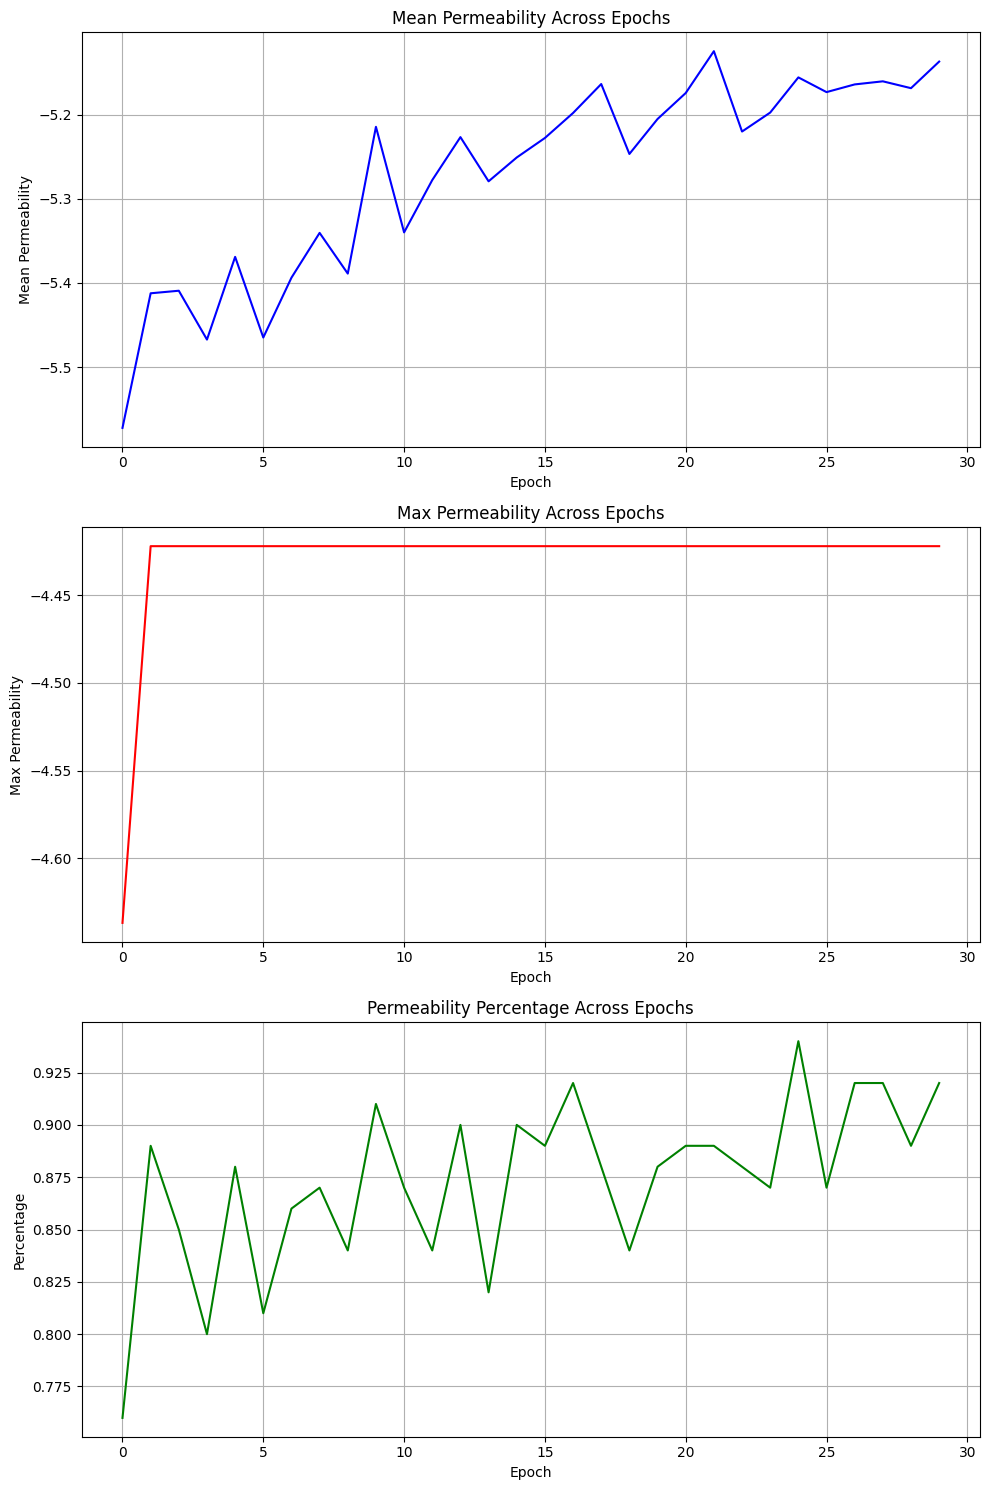

In [23]:
GA_population = run_genetic_algorithm(num_epochs=num_epochs, convergence_percentage=convergence_percentage, plot=True)

In [76]:
def generate_experimental_setup(GA_population, size_limit):
    df = GA_population.sort_values(by='Permeability', ascending=False)
# Get size limit from user


# Initialize an empty set for collecting unique strings
    unique_strings = set()

# Iterate through the sorted DataFrame
    for sequence in df['Sequence']:
        for item in sequence:
            unique_strings.add(item)
            if len(unique_strings) >= size_limit:
                break
        if len(unique_strings) >= size_limit:
            break

# Convert set to list and return
    result_list = list(unique_strings)
    filtered_top_set = top_set[top_set['Name'].isin(result_list)]

    return filtered_top_set, result_list

def filter_sequences(df, target_strings):
    """
    Filters a DataFrame to return only rows where the 'Sequence' column contains
    the specified string(s).

    Parameters:
    df (pd.DataFrame): DataFrame to be filtered.
    target_strings (str or list): String or list of strings to look for in each 'Sequence'.

    Returns:
    pd.DataFrame: A DataFrame containing only the rows where 'Sequence' contains the target string(s).
    """
    if isinstance(target_strings, str):
        target_strings = [target_strings]  # Convert single string to list for uniform processing

    # Use apply to create a mask where we check if any of the target strings are in the 'Sequence' list
    mask = df['Sequence'].apply(lambda seq: any(item in seq for item in target_strings))
    return df[mask].sort_values(by='Permeability', ascending=False)





In [ ]:
test_1, list_1 = generate_experimental_setup(GA_population, size_limit=10)
filtered_df = filter_sequences(GA_population, list_1)
filtered_df

In [49]:
# # Convert the lists to strings and find the unique values directly
# unique_sequences = pd.Series([str(x) for x in GA_population['Sequence']]).unique()
# len(unique_sequences)


In [ ]:

# peptides_and_structures = generate_initial_cyclic_peptide_population(
#     top_set, population_size=population_size, min_len=3, max_len=4, 
#     allow_repetitions=False, type_of_cyclization='disulfide')      
# population = generate_permeability_df(peptides_and_structures)
# selected = selection(population, fraction=crossover_fraction)
# pairs_of_sequences = select_parents(selected, allow_cheating=False)
# new_generation_df = generate_children_df(pairs_of_sequences)
# mutated_df = mutate_generation(new_generation_df, fraction=mutation_fraction/crossover_fraction, bbdict=bbdict)
# final_generation = append_long_livers(population, mutated_df, long_liver_fraction=long_liver_fraction)
# mean_permeability, max_permeability, permeability_percentage = calculate_df_metrics(final_generation)

In [ ]:
# unique_sequences = pd.Series([str(x) for x in population['Sequence']]).unique()
# len(unique_sequences)

In [ ]:
# selected = selection(population, fraction=crossover_fraction)
# pairs_of_sequences = select_parents(selected, allow_cheating=False)
# new_generation_df = generate_children_df(pairs_of_sequences)

In [ ]:
# unique_sequences = pd.Series([str(x) for x in new_generation_df['Sequence']]).unique()
# len(unique_sequences)

In [ ]:
# mutated_df = mutate_generation(new_generation_df, fraction=mutation_fraction/crossover_fraction, bbdict=bbdict)


In [ ]:
# unique_sequences = pd.Series([str(x) for x in mutated_df['Sequence']]).unique()
# len(unique_sequences)

In [ ]:
# final_generation = append_long_livers(population, mutated_df, long_liver_fraction=long_liver_fraction)

In [82]:
# unique_sequences = pd.Series([str(x) for x in final_generation['Sequence']]).unique()
# len(unique_sequences)

In [ ]:
# final_generation